# 使用XGBoost的Amazon SageMaker多模型端点
借助[Amazon SageMaker多模型终端节点]（https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html），客户可以创建无缝托管多达数千个模型的终端节点。这些端点非常适合以下情况：大量模型中的任何一个（可以从公共推理容器中提供以节省推理成本）需要按需调用，并且不经常调用的模型可以接受这些情况一些额外的延迟。对于要求持续低推理延迟的应用程序，部署单一模型的端点仍然是最佳选择。

在较高级别，Amazon SageMaker可根据需要管理多模型终端节点的模型加载和卸载。当针对特定模型发出调用请求时，Amazon SageMaker将请求路由到分配给该模型的实例，将模型工件从S3下载到该实例，然后启动将模型加载到容器的内存中。加载完成后，Amazon SageMaker会执行请求的调用并返回结果。如果模型已经在选定实例的内存中加载，则跳过下载和加载步骤，并立即执行调用。

为了演示如何创建和使用多模型端点，此笔记本提供了一个示例，其中使用了一组XGBoost模型，每个模型都可以预测单个位置的房价。该域用作简单示例，可以轻松地尝试使用多模型端点。

Amazon SageMaker多模型终端功能旨在与Mxnet，PyTorch和Scikit-Learn机器学习框架（即将推出TensorFlow），SageMaker XGBoost，KNN和Linear Learner算法一起使用。

此外，Amazon SageMaker多模型终端节点还设计用于在您自带与多模型服务器库集成的容器的情况下使用。可以在[here]（https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/multi_model_bring_your_own）和文档[here。]（https://docs.aws。 amazon.com/sagemaker/latest/dg/build-multi-model-build-container.html）


### Contents

1. [Generate synthetic data for housing models](#Generate-synthetic-data-for-housing-models)
1. [Train multiple house value prediction models](#Train-multiple-house-value-prediction-models)
1. [Create the Amazon SageMaker MultiDataModel entity](#Create-the-Amazon-SageMaker-MultiDataModel-entity)
  1. [Create the Multi-Model Endpoint](#Create-the-multi-model-endpoint)
  1. [Deploy the Multi-Model Endpoint](#deploy-the-multi-model-endpoint)
1. [Get Predictions from the endpoint](#Get-predictions-from-the-endpoint)
1. [Additional Information](#Additional-information)
1. [Clean up](#Clean-up)

In [15]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import os 
from datetime import datetime
from time import gmtime, strftime, sleep
import boto3
import sagemaker
from sagemaker import get_execution_role
#from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from time import sleep
import time

region = boto3.Session().region_name    
smclient = boto3.Session().client('sagemaker')

role = sagemaker.get_execution_role()
bucket = sagemaker.Session().default_bucket()

prefix = 'xgb-10000871.csv-TC58-SW100-WC60-20201202011847'
prefix_target_model = 'TC58-SW100-WC60.tar.gz'
s3_wholedata_path = s3_data='s3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix)
endpoint_name = 'mme-xgb-TC58-SW100-WC99to10-v2' #'xgb-TC58-SW100-WC60-temp01'


#!pip install s3fs -U
role = get_execution_role()
model_data = pd.read_csv(s3_wholedata_path)
#model_data.head(3) #for testing
#model_data.info() #for testing

#print(bucket)
#print(prefix)
#print(prefix_target_model)
print(prefix)
print(endpoint_name)


xgb-10000871.csv-TC58-SW100-WC60-20201202011847
mme-xgb-TC58-SW100-WC99to10-v2


In [2]:
#预测 1：准备sagemaker endpoint
xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

#from sagemaker.predictor import csv_serializer
from sagemaker.predictor import csv_serializer, json_deserializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [7]:
# inference预测处理：传入modeldata数据和 sagemaker inference handle，获得预测结果
def sagemaker_predict(data, xgb_predictor, target_model, rows=100):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))    
    predictions = ''
    for array in split_array:
        split_result = xgb_predictor.predict(data=array, target_model=target_model).decode('utf-8')
        #print(split_result)
        split_result = str.strip(split_result, '[]') # 去掉多余的前后[]符号
        #split_result=split_result.replace(' ', '')
        #print('res='+split_result)
             
        predictions = ','.join([predictions, split_result])
            
    #print(predictions)
    #return np.fromstring(predictions[1:], sep=',', dtype=np.float64) 
    return np.fromstring(predictions[1:], sep=',') 

#预测 2：预测并获得预测结果
model_data_to_numpy = model_data.to_numpy()[:, 1:] #转换所有的行，从第一列开始（忽略0列）

#调用函数
predictions = sagemaker_predict(model_data_to_numpy,xgb_predictor, prefix_target_model, rows=100)
#print('predictions=')
#print(predictions)
#print('predictions round=')
#print(np.round(predictions))
#print('\n')
#print('expect round=')
#print(model_data.to_numpy()[:, 0:1])

model_data: 1=19, 0=2000 / 
predictions Result: 1=15, 0=2004


predictions_data,0.0,1.0
model_data,,
0.0,2000,0
1.0,4,15


<Figure size 432x288 with 0 Axes>

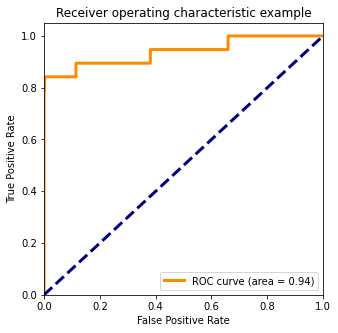

sklearn AUC: 0.9391052631578947

xgb_predictor.endpoint = mme-xgb-TC58-SW100-WC99to10-v2

s3_wholedata_path = s3://sagemaker-us-west-2-153705321444/xgb-10000871.csv-TC58-SW100-WC60-20201202011847/wholedata/whole_data.csv


(None,)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#from xgboost import XGBRegressor
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

y_labels = model_data.iloc[:, 0]
y_scores = predictions

#结果 1：测试数据集结果 与 预测结果 的数量对比
print('model_data: 1='+ str((y_labels == 1).sum()) + ', 0='+str((y_labels == 0).sum()) +' / '),
print('predictions Result: 1='+ str((np.round(y_scores) == 1).sum()) + ', 0='+str((np.round(y_scores) == 0).sum()))

#结果 2：交叉表，说明 测试数据集结果 与 预测结果 的正确情况对比
display(pd.crosstab(index=model_data.iloc[:, 0], columns=np.round(predictions), 
            rownames=['model_data'], colnames=['predictions_data'],margins=False))
#print('\n')

#结果 4：ROC图，越大越好，无限接近与1
from sklearn.metrics import roc_curve, auc                     #导入库
fpr, tpr, thresholds  =  roc_curve(y_labels, y_scores)  #计算真正率和假正率
roc_auc = auc(fpr,tpr)                                         #计算auc的值
plt.figure()
lw = 3
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#结果 3：AUC值，越大越好，无限接近与1
import numpy as np
from sklearn.metrics import roc_auc_score
##y_labels=[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
##y_scores=[4.92438182e-01 1.74370125e-01 8.58997216e-01 1.30175965e-01 
# 调用sklearn中的方法计算AUC，与后面自己写的方法作对比
print('sklearn AUC:', roc_auc_score(y_labels, y_scores))
#打印全局变量值
print('\nxgb_predictor.endpoint = ' + str(xgb_predictor.endpoint)),
print('\ns3_wholedata_path = '+ str(s3_wholedata_path)),


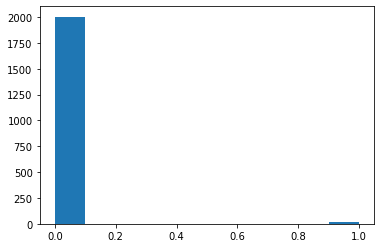

predictions_data,0,1
model_data,,
0.0,2000,0
1.0,4,15


In [9]:
#结果 5：分布柱状图；用于分析和优化结果（round函数）；
plt.hist(predictions, bins=10, range=(0, 1))
plt.show()

#用于分析和优化结果（round函数）；
round_predictions=0.45
pd.crosstab(index=model_data.iloc[:, 0], columns=np.where(predictions > round_predictions, 1, 0), 
            rownames=['model_data'], colnames=['predictions_data'],margins=False)


# 使用XGBoost的Amazon SageMaker多模型端点

In [16]:
prefix_WC10 = 'xgb-10000871.csv-TC58-SW100-WC10-20201202080714'
prefix_model_WC10 = 'TC58-SW100-WC10.tar.gz'
s3_wholedata_path_WC10 = 's3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix_WC10)

prefix_WC20 = 'xgb-10000871.csv-TC58-SW100-WC20-20201202051756'
prefix_model_WC20 = 'TC58-SW100-WC20.tar.gz'
s3_wholedata_path_WC20 = 's3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix_WC20)

prefix_WC40 = 'xgb-10000871.csv-TC58-SW100-WC40-20201202032834'
prefix_model_WC40 = 'TC58-SW100-WC40.tar.gz'
s3_wholedata_path_WC40 = 's3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix_WC40)

prefix_WC60 = 'xgb-10000871.csv-TC58-SW100-WC60-20201202011847'
prefix_model_WC60 = 'TC58-SW100-WC60.tar.gz'
s3_wholedata_path_WC60 = 's3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix_WC60)

prefix_WC80 = 'xgb-10000871.csv-TC58-SW100-WC80-20201202023456'
prefix_model_WC80 = 'TC58-SW100-WC80.tar.gz'
s3_wholedata_path_WC80 = 's3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix_WC80)

prefix_WC100 = 'xgb-10000871.csv-TC58-SW100-WC99-20201202064356'
prefix_model_WC100 = 'TC58-SW100-WC99.tar.gz'
s3_wholedata_path_WC100 = 's3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix_WC100)

endpoint_name = 'mme-xgb-TC58-SW100-WC99to10-v2' 

In [11]:
model_data_WC10 = pd.read_csv(s3_wholedata_path_WC10)
model_data_WC20 = pd.read_csv(s3_wholedata_path_WC20)
model_data_WC40 = pd.read_csv(s3_wholedata_path_WC40)
model_data_WC60 = pd.read_csv(s3_wholedata_path_WC60)
model_data_WC80 = pd.read_csv(s3_wholedata_path_WC80)
model_data_WC100 = pd.read_csv(s3_wholedata_path_WC100)


In [17]:
#预测 1：准备sagemaker endpoint
xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

#from sagemaker.predictor import csv_serializer
from sagemaker.predictor import csv_serializer, json_deserializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
#xgb_predictor.deserializer = json_deserializer
#xgb_predictor.deserializer = None

In [20]:
from time import sleep
import time

# inference预测处理 - string deserializer 字符串处理后取回
def predict_multimodel_matchrow_v1(multimodel, modelmatchrow, xgb_predictor):    
    xgb_predictor.deserializer = None
    modelmatch_predictions=''
    #t_res = ''
    for i in range(0,len(multimodel)):
        #print(modelmatchrow[i])
        #modelmatch_predictions.append(xgb_predictor.predict(data=modelmatchrow[i], target_model=multimodel[i]).decode('utf-8'))  
        t_res = xgb_predictor.predict(data=modelmatchrow[i], target_model=multimodel[i]).decode('utf-8')        
        #print(t_res)
        t_res = str.strip(t_res, '[]') # 去掉多余的前后[]符号        
        #print(t_res)
        modelmatch_predictions = ','.join([modelmatch_predictions, t_res])

    #print(modelmatch_predictions)        
    #return np.fromstring(predictions[1:], sep=',', dtype=np.float64) 
    return np.fromstring(modelmatch_predictions[1:], sep=',', dtype=np.float) 


# inference预测处理 - json_deserializer 数组原生取回
def predict_multimodel_matchrow_v2(multimodel, modelmatchrow, xgb_predictor):    
    xgb_predictor.deserializer = json_deserializer
    modelmatch_predictions=[]   
    for i in range(0,len(multimodel)):
        modelmatch_predictions.append(xgb_predictor.predict(data=modelmatchrow[i], target_model=multimodel[i]))  

    return modelmatch_predictions 


def predict_result_factory(warningcycle, multimodel, modelmatchrow, predictions, predictionsround, expectround):    
    from datetime import datetime
    from pytz import timezone

    fmt = "%Y-%m-%d %H:%M:%S"
    now_time = datetime.now(timezone('Asia/Shanghai'))
    now_time = (now_time.strftime(fmt))

    res = {'datetime_now':now_time, 
           '01_warningcycle':warningcycle[0],'01_modelname':multimodel[0], '01_data':str(modelmatchrow[0]).replace('\n', '').replace('\r', ''), '01_predictscore':predictions[0], '01_predictround':predictionsround[0], '01_expectround':expectround[0],
           '02_warningcycle':warningcycle[1],'02_modelname':multimodel[1], '02_data':str(modelmatchrow[1]).replace('\n', '').replace('\r', ''), '02_predictscore':predictions[1], '02_predictround':predictionsround[1], '02_expectround':expectround[1],
           '03_warningcycle':warningcycle[2],'03_modelname':multimodel[2], '03_data':str(modelmatchrow[2]).replace('\n', '').replace('\r', ''), '03_predictscore':predictions[2], '03_predictround':predictionsround[2], '03_expectround':expectround[2],
           '04_warningcycle':warningcycle[3],'04_modelname':multimodel[3], '04_data':str(modelmatchrow[3]).replace('\n', '').replace('\r', ''), '04_predictscore':predictions[3], '04_predictround':predictionsround[3], '04_expectround':expectround[3],
           '05_warningcycle':warningcycle[4],'05_modelname':multimodel[4], '05_data':str(modelmatchrow[4]).replace('\n', '').replace('\r', ''), '05_predictscore':predictions[4], '05_predictround':predictionsround[4], '05_expectround':expectround[4],
           '06_warningcycle':warningcycle[5],'06_modelname':multimodel[5], '06_data':str(modelmatchrow[5]).replace('\n', '').replace('\r', ''), '06_predictscore':predictions[5], '06_predictround':predictionsround[5], '06_expectround':expectround[5],
          }    
    return res


In [ ]:
prefix = 'xgb-10000871.csv-TC58-SW100-WC99to10-MultiModel'
s3_predictresult_path = 's3://{}/{}/predictionsresult_data02.csv'.format(bucket, prefix)
print(s3_predictresult_path)

p_multimodel = [prefix_model_WC10,prefix_model_WC20,prefix_model_WC40,prefix_model_WC60,prefix_model_WC80,prefix_model_WC100]
p_warningcycle = [10,20,40,60,80,100]
p_matchrow = []

predict_result = pd.DataFrame(columns=('datetime_now',
                            '01_warningcycle','01_modelname', '01_data', '01_predictscore', '01_predictround', '01_expectround',
                            '02_warningcycle','02_modelname', '02_data', '02_predictscore', '02_predictround', '02_expectround',
                            '03_warningcycle','03_modelname', '03_data', '03_predictscore', '03_predictround', '03_expectround',
                            '04_warningcycle','04_modelname', '04_data', '04_predictscore', '04_predictround', '04_expectround',
                            '05_warningcycle','05_modelname', '05_data', '05_predictscore', '05_predictround', '05_expectround',
                            '06_warningcycle','06_modelname', '06_data', '06_predictscore', '06_predictround', '06_expectround'
                           ))

i=0
model_data_len = len(model_data_WC10)

while i < model_data_len:
    
    p_matchrow = [model_data_WC10.to_numpy()[:, 1:][i], model_data_WC20.to_numpy()[:, 1:][i], 
                  model_data_WC40.to_numpy()[:, 1:][i], model_data_WC60.to_numpy()[:, 1:][i],
                  model_data_WC80.to_numpy()[:, 1:][i], model_data_WC100.to_numpy()[:, 1:][i]]
    
    p_matchrow_expectscore = [model_data_WC10.to_numpy()[:, 0:1][i], model_data_WC20.to_numpy()[:, 0:1][i], 
                  model_data_WC40.to_numpy()[:, 0:1][i], model_data_WC60.to_numpy()[:, 0:1][i],
                  model_data_WC80.to_numpy()[:, 0:1][i], model_data_WC100.to_numpy()[:, 0:1][i]]
        
    #print(p_multimodel)
    predictions = predict_multimodel_matchrow_v2(p_multimodel,p_matchrow,xgb_predictor)
    #print(predictions)
    predictionsround=np.round(predictions)
    #print(p_matchrow_expectscore)    
    t_predict_result = predict_result_factory(p_warningcycle, p_multimodel, p_matchrow, predictions, predictionsround, p_matchrow_expectscore)
    #print(t_predict_result)    
    predict_result = predict_result.append(t_predict_result, ignore_index=True)
    predict_result.to_csv(s3_predictresult_path)    
    print('cycle number={0}, resutl size={1}'.format(i, predict_result.size))

    i+=1    
    if (i == model_data_len): 
        i=0
    time.sleep(10)


    

s3://sagemaker-us-west-2-153705321444/xgb-10000871.csv-TC58-SW100-WC99to10-MultiModel/predictionsresult_data02.csv
cycle number=0, resutl size=37
cycle number=1, resutl size=74
cycle number=2, resutl size=111
cycle number=3, resutl size=148
cycle number=4, resutl size=185
cycle number=5, resutl size=222
cycle number=6, resutl size=259
cycle number=7, resutl size=296
cycle number=8, resutl size=333
cycle number=9, resutl size=370
cycle number=10, resutl size=407
cycle number=11, resutl size=444
cycle number=12, resutl size=481
cycle number=13, resutl size=518
cycle number=14, resutl size=555
cycle number=15, resutl size=592
cycle number=16, resutl size=629
cycle number=17, resutl size=666
cycle number=18, resutl size=703
cycle number=19, resutl size=740
cycle number=20, resutl size=777
cycle number=21, resutl size=814
cycle number=22, resutl size=851
cycle number=23, resutl size=888
cycle number=24, resutl size=925
cycle number=25, resutl size=962
cycle number=26, resutl size=999
cycle 

for row in model_data.iteritems():
    print(row) # 输出各列
    predictions = sagemaker_predict(model_data_to_numpy,xgb_predictor, prefix_target_model, rows=100)    
    break
    

    s3_predictions=[]   
    for i in range(0,len(multimodel)):
        modelmatch_predictions.append(xgb_predictor.predict(data=modelmatchrow[i], target_model=multimodel[i]))  

    return modelmatch_predictions 


from datetime import datetime
from pytz import timezone

fmt = "%Y-%m-%d %H:%M:%S"
now_time = datetime.now(timezone('Asia/Shanghai'))
now_time = (now_time.strftime(fmt))


res = pd.DataFrame(columns=('datetime_now',
                            '01_modelname', '01_data', '01_predictscore', '01_predictround', '01_expectround',
                            '02_modelname', '02_data', '02_predictscore', '02_predictround', '02_expectround',
                            '03_modelname', '03_data', '03_predictscore', '03_predictround', '03_expectround',
                            '04_modelname', '04_data', '04_predictscore', '04_predictround', '04_expectround',
                            '05_modelname', '05_data', '05_predictscore', '05_predictround', '05_expectround',
                            '06_modelname', '06_data', '06_predictscore', '06_predictround', '06_expectround'
                           ))
res = res.append([
    {'datetime_now':now_time, '01_modelname':now_time, '01_data':now_time, '01_predictscore':now_time, '01_predictround':now_time, '01_expectround':now_time}
                 ], ignore_index=True)
print(res.head(1))


s3_predictresult_path = 's3://{}/{}/wholedata/s3_predictions.csv'.format(bucket, prefix)
print(s3_predictresult_path)

res.to_csv(s3_predictresult_path)